
# Suivi de tempêtes dans les réanalyses ERA5 - Diagramme de phase

**Auteur : Frédéric FERRY - Ecole Nationale de la Météorologie (Météo France)**

Le diagramme de phase des cyclones (Cyclone Phase Space Diagram : moe.met.fsu.edu/~rhart/papers-hart/2003Hart.pdf) est un outil diagnostique utile permettant de caractériser la structure thermodynamique des cyclones tropicaux et extra-tropicaux. Il se base sur l'analyse de la symétrie thermique du système dans la basse troposphère et sur sa structure à cœur chaud ou à cœur froid dans la basse et la haute troposphère.

Les paramètres utilisés pour construire ce diagnostic permettent de décrire la structure à cœur chaud d'un cyclone tropical, la structure à cœur froid d'un cyclone extra-tropical ainsi que ses stades de développement (formation, intensification, occlusion, affaiblissement, développement de séclusions chaudes). Cet outil permet aussi d'analyser la structure hybride des cyclones subtropicaux et de suivre les transtions tropicales de cyclones subtropicaux ou transitions extra-tropicales de cyclones tropicaux.

Le présent calepin permet :
- Le suivi d'une tempête à partir de réanalyses ERA5 de Pmer et de géopotentiel et d'un fichier .txt de tracking obtenu grâce à un programme de tracking automatique (non fourni ici)
- Le calcul pas à pas des paramètres de symétrie thermique et de cœur chaud/cœur froid du diagrammme de phase
- Le tracé du diagramme de phase tel que disponible sur http://moe.met.fsu.edu/cyclonephase/

Le diagramme de phase est ici illustré avec le cas de la transition extra-tropicale du cyclone tropical Ophelia (octobre 2017)

Pour faire fonctionner ce calepin il est nécessaire de télécharger les données ERA5 au format netcdf, au pas de temps horaire et sur domaine limité (-100W-50E, 0-90N) :
- https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form
- https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form

In [1]:
import os

import xarray as xr
import netCDF4

import math
import numpy as np
from scipy.ndimage import gaussian_filter

from cartopy import config
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.collections as collections

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

from sklearn.linear_model import LinearRegression

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):

    from scipy.ndimage import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        #print('Low '+str(i+1))
        #print(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], int(data[mxy[i], mxx[i]]))
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=12,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(int(data[mxy[i], mxx[i]])),
                color=color, size=10, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

In [3]:
def make_animation(gif_filepath):
    from PIL import Image
    import os
    from IPython.display import Image as IPImage
    from IPython.display import display
    import time
    
    image_folder = './anim/'+storm+'/' # répertoire contenant les fichiers PNG
    output_file = gif_filepath # nom du fichier de sortie
    animation_speed = 0.9 # vitesse de l'animation en secondes
    
    # Liste tous les fichiers PNG dans le répertoire image_folder
    files = sorted(os.listdir(image_folder))
    image_files = [f for f in files if f.endswith('.png')]
    
    # Ouvre chaque fichier PNG et ajoute l'image à une liste
    images = []
    for filename in image_files:
        img = Image.open(os.path.join(image_folder, filename))
        images.append(img)
    
    # Crée l'animation GIF
    images[0].save(output_file, save_all=True, append_images=images[1:], duration=int(animation_speed*1000), loop=0)
    # Affiche l'animation GIF dans Jupyter
    with open(output_file,'rb') as f:
        display(IPImage(data=f.read(), format='png'))
    # Efface les fichiers PNG
    for filename in image_files:
        os.remove(image_folder+filename)

In [4]:
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1 = np.deg2rad(lon1)
    lon2 = np.deg2rad(lon2)
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371
    return c * r

In [5]:
def get_bearing(lat1, lon1, lat2, lon2):
    dLon = (lon2 - lon1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)
    brng = (brng +360) % 360
    return brng

# Trajectoires de toutes les tempêtes

In [6]:
storms=['Nov1982', 'Oct1987', 'Herta', 'Viviane', 'Braer', 'Lothar', 'Martin', 'Klaus', 'Xynthia',
        'Joachim', 'Zeus', 'Ophelia', 'Eleanor', 'Zorbas', 'Lorenzo', 'Alex', 'Ciaran']

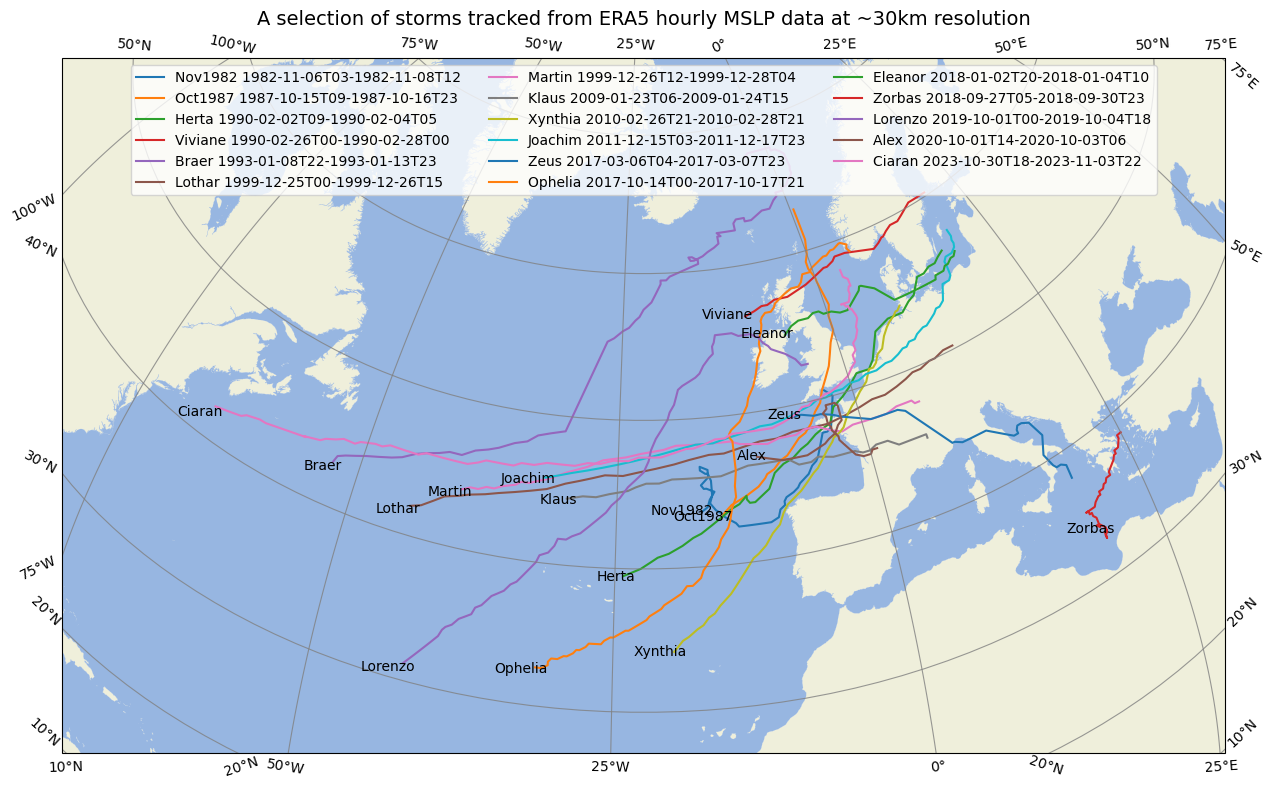

In [53]:
latS=25
latN=70
lonW=-75
lonE=30
bounds = [(lonW, lonE, latS, latN)]
projection=ccrs.NearsidePerspective(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)
                             
fig = plt.figure(figsize=(15., 10.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('A selection of storms tracked from ERA5 hourly MSLP data at ~30km resolution',loc='center',fontsize=14)
ax.gridlines(draw_labels=True, color='gray', alpha=0.8, linestyle='-')
#ax.stock_img()
LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='face',facecolor=cfeature.COLORS['land'],linewidth=.1)
ax.add_feature(LAND)
OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',edgecolor='face',facecolor=cfeature.COLORS['water'],linewidth=.1)
ax.add_feature(OCEAN)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())

for storm in storms:
    liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',skiprows=0, dtype='U13,float,float,int',unpack=True)
    date1=str(liste_time[0])
    date2=str(liste_time[-1])
    ax.plot(liste_lon,liste_lat, transform=ccrs.PlateCarree(), label=storm+' '+date1+'-'+date2)
    ax.text(liste_lon[0]+1, liste_lat[0], storm, verticalalignment='center', horizontalalignment='right',transform=ccrs.PlateCarree())

ax.legend(loc="upper center", ncol=3)
plt.show()

figname='./figs/tracks2'
fig.savefig(figname+'.png')

# Suivi d'une tempête

In [8]:
def print_menu():
    print ('1 -- Tempête de Novembre 1982' )
    print ("2 -- 'Ourangan' d'octobre 1987")
    print ('3 -- Herta - Février 1990' )
    print ('4 -- Viviane - Février 1990' )
    print ('5 -- Braer - Janvier 1993' )
    print ('6 -- Lothar - Décembre 1999' )
    print ('7 -- Martin - Décembre 1999' )
    print ('8 -- Klaus - Janvier 2009' )
    print ('9 -- Xynthia - Février 2010' )
    print ('10 -- Joachim - Décembre 2011' )
    print ('11 -- Zeus - Mars 2017' )
    print ('12 -- Ophelia - Octobre 2017 (transition extra tropicale)' )
    print ('13 -- Eleanor - Janvier 2018' )
    print ('14 -- Zorbas - Septembre 2018 (medicane)')
    print ('15 -- Lorenzo - Octobre 2019 (transition extra tropicale)' )
    print ('16 -- Alex - Octobre 2020' )
    print ('17 -- Ciaran - Octobre-novembre 2023' )

print_menu()

option = int(input('Enter number of the desired storm : ')) 
if option == 1:
    storm='Nov1982'
elif option == 2:
    storm='Oct1987'
elif option == 3:
    storm='Herta'
elif option == 4:
    storm='Viviane'
elif option == 5:
    storm='Braer'
elif option == 6:
    storm='Lothar'
elif option == 7:
    storm='Martin'
elif option == 8:
    storm='Klaus'
elif option == 9:
    storm='Xynthia'
elif option == 10:
    storm='Joachim'
elif option == 11:
    storm='Zeus'
elif option == 12:
    storm='Ophelia'
elif option == 13:
    storm='Eleanor'
elif option == 14:
    storm='Zorbas'
elif option == 15:
    storm='Lorenzo'
elif option == 16:
    storm='Alex'
elif option == 17:
    storm='Ciaran'

else:
    print('Invalid option. Please enter a number between 1 and 17.')

dir_figs='./figs/'+storm+'/CPS/'
dir_anim='./anim/'+storm+'/'

if not os.path.exists(dir_figs):
    os.mkdir(dir_figs)
    
if not os.path.exists(dir_anim):
    os.mkdir(dir_anim)

1 -- Tempête de Novembre 1982
2 -- 'Ourangan' d'octobre 1987
3 -- Herta - Février 1990
4 -- Viviane - Février 1990
5 -- Braer - Janvier 1993
6 -- Lothar - Décembre 1999
7 -- Martin - Décembre 1999
8 -- Klaus - Janvier 2009
9 -- Xynthia - Février 2010
10 -- Joachim - Décembre 2011
11 -- Zeus - Mars 2017
12 -- Ophelia - Octobre 2017 (transition extra tropicale)
13 -- Eleanor - Janvier 2018
14 -- Zorbas - Septembre 2018 (medicane)
15 -- Lorenzo - Octobre 2019 (transition extra tropicale)
16 -- Alex - Octobre 2020
17 -- Ciaran - Octobre-novembre 2023
Enter number of the desired storm : 1


In [9]:
latS=30
latN=70
lonW=-60
lonE=30

if storm=='Braer':
    latS=40
    latN=80
    lonW=-80
    lonE=20
if storm=='Ciaran':
    latS=30
    latN=70
    lonW=-70
    lonE=30
if storm=='Lorenzo':
    latS=25
    latN=60
    lonW=-60
    lonE=20
if storm=='Zorbas':
    latS=30
    latN=45
    lonW=5
    lonE=35
    
bounds = [(lonW, lonE, latS, latN)]

In [10]:
liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',
        skiprows=0, dtype='U13,float,float,int',unpack=True)
print(liste_time)

['1982-11-06T03' '1982-11-06T04' '1982-11-06T05' '1982-11-06T06'
 '1982-11-06T07' '1982-11-06T08' '1982-11-06T09' '1982-11-06T10'
 '1982-11-06T11' '1982-11-06T12' '1982-11-06T13' '1982-11-06T14'
 '1982-11-06T15' '1982-11-06T16' '1982-11-06T17' '1982-11-06T18'
 '1982-11-06T19' '1982-11-06T20' '1982-11-06T21' '1982-11-06T22'
 '1982-11-06T23' '1982-11-07T00' '1982-11-07T01' '1982-11-07T02'
 '1982-11-07T03' '1982-11-07T04' '1982-11-07T05' '1982-11-07T06'
 '1982-11-07T07' '1982-11-07T08' '1982-11-07T09' '1982-11-07T10'
 '1982-11-07T11' '1982-11-07T12' '1982-11-07T13' '1982-11-07T14'
 '1982-11-07T15' '1982-11-07T16' '1982-11-07T17' '1982-11-07T18'
 '1982-11-07T19' '1982-11-07T20' '1982-11-07T21' '1982-11-07T22'
 '1982-11-07T23' '1982-11-08T00' '1982-11-08T01' '1982-11-08T02'
 '1982-11-08T03' '1982-11-08T04' '1982-11-08T05' '1982-11-08T06'
 '1982-11-08T07' '1982-11-08T08' '1982-11-08T09' '1982-11-08T10'
 '1982-11-08T11' '1982-11-08T12']


In [11]:
interval=int(input("Enter the desired time step (3h or 6h advised): "))

liste_time=liste_time[::interval]
liste_lon=liste_lon[::interval]
liste_lat=liste_lat[::interval]
liste_pres=liste_pres[::interval]

print(liste_time)
print(liste_time.shape)

date1=str(liste_time[0])
date2=str(liste_time[-1])

Enter the desired time step (3h or 6h advised): 6
['1982-11-06T03' '1982-11-06T09' '1982-11-06T15' '1982-11-06T21'
 '1982-11-07T03' '1982-11-07T09' '1982-11-07T15' '1982-11-07T21'
 '1982-11-08T03' '1982-11-08T09']
(10,)


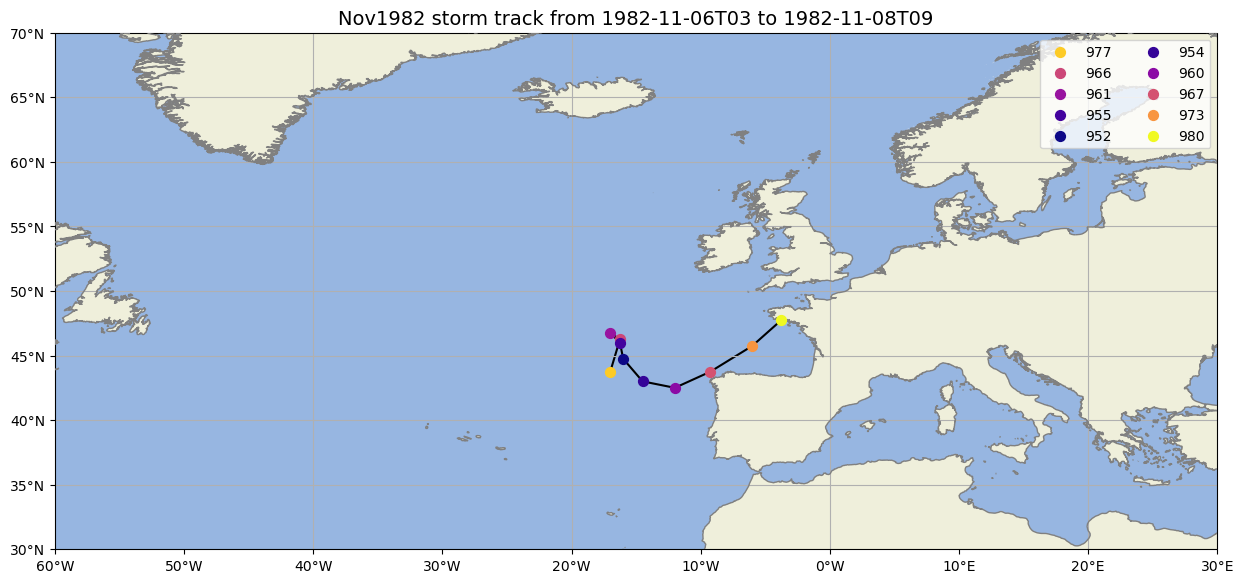

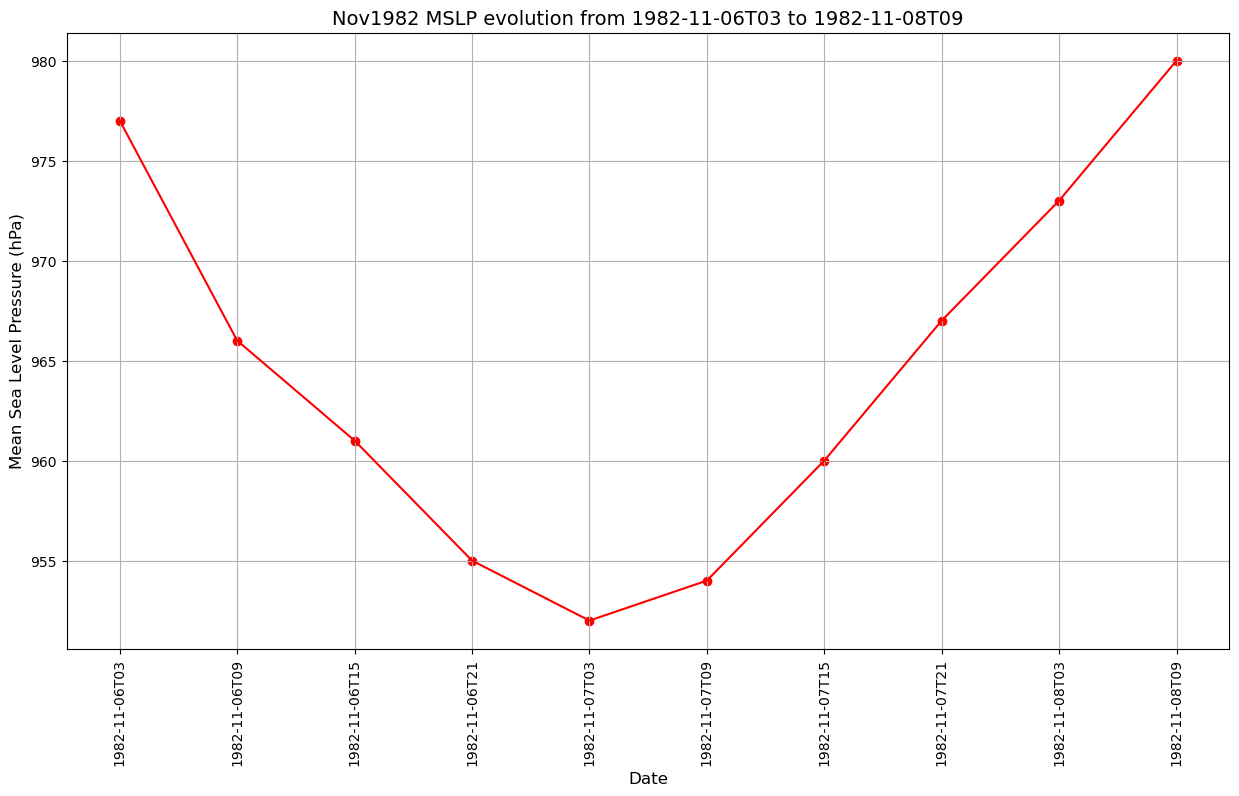

In [12]:
def plot_background(ax):
    ax.coastlines("10m", zorder=3, color='grey')
    ax.gridlines()
    ax.set_xticks(np.linspace(-180, 180, 37), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90, 90, 37), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return(ax)

projection=ccrs.PlateCarree()

vmin = np.min(liste_pres)
vmax = np.max(liste_pres)

fig = plt.figure(figsize=(15., 15.))
ax = fig.add_subplot(111, projection=projection)
ax.set_title(storm+' storm track from '+liste_time[0]+' to '+liste_time[-1],loc='center',fontsize=14)

#ax.stock_img()
LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='face',facecolor=cfeature.COLORS['land'],linewidth=.1)
ax.add_feature(LAND)
OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',edgecolor='face',facecolor=cfeature.COLORS['water'],linewidth=.1)
ax.add_feature(OCEAN)
# Create a Stamen terrain background instance.
#stamen_terrain = cimgt.Stamen('terrain-background')
# Add the Stamen data at zoom level 8.
#ax.add_image(stamen_terrain, 8)
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())

ax.plot(liste_lon,liste_lat, color='k', transform=ccrs.PlateCarree())
for i in range(len(liste_time)):
    ax.scatter(liste_lon[i],liste_lat[i], c=liste_pres[i],
               cmap='plasma', vmin=vmin, vmax=vmax, s=50,
               label=liste_pres[i],transform=ccrs.PlateCarree(), zorder=10)

plt.legend(ncol=2)
plt.show()
figname=dir_figs+storm+'_era_track'
fig.savefig(figname+'.png')

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title(storm+' MSLP evolution from '+liste_time[0]+' to '+liste_time[-1],loc='center',fontsize=14)
ax.scatter(liste_time,liste_pres, color='red')
ax.plot(liste_time,liste_pres, color='red')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean Sea Level Pressure (hPa)', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.grid()
ax.tick_params(axis='x', labelsize=10)

plt.show()
figname=dir_figs+storm+'_era_slp_evolution'
fig.savefig(figname+'.png')

In [13]:
dir_data="E:/BIG_DATA/ERA5_storms/data/"

f1    = xr.open_dataset(dir_data+storm+"/msl.nc")
f2    = xr.open_dataset(dir_data+storm+"/z.nc")
print(f1)
print(f2)

<xarray.Dataset>
Dimensions:    (longitude: 601, latitude: 361, time: 72)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... 49.5 49.75 50.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 1982-11-06 ... 1982-11-08T23:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-04-23 07:55:10 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 601, latitude: 361, level: 27, time: 72)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... 49.5 49.75 50.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 100 125 150 175 200 225 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 1982-11-06 ... 1982-11-08T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
Attributes:
    Conv

In [14]:
interval=int(input("Enter the desired time interval to match with track data : "))

Enter the desired time interval to match with track data : 6


In [15]:
f1    = xr.open_dataset(dir_data+storm+"/msl.nc").sel(
    time=slice(date1,date2)).sel(
    latitude=slice(latN,latS)).sel(
    longitude=slice(lonW,lonE))

mslp = f1['msl'][::interval]/100
lat  = mslp.latitude.values
time  = mslp.time.values
lon  = mslp.longitude.values

print(mslp)

<xarray.DataArray 'msl' (time: 10, latitude: 161, longitude: 361)>
array([[[1008.01447, 1007.9819 , 1007.9519 , ..., 1014.949  ,
         1014.9099 , 1014.87726],
        [1008.2922 , 1008.24   , 1008.2074 , ..., 1014.95166,
         1014.8995 , 1014.86945],
        [1008.6625 , 1008.6065 , 1008.5517 , ..., 1014.96204,
         1014.932  , 1014.90466],
        ...,
        [1024.1343 , 1024.1838 , 1024.2125 , ..., 1013.43896,
         1013.4846 , 1013.5173 ],
        [1023.95953, 1024.0026 , 1024.0391 , ..., 1013.5851 ,
         1013.63983, 1013.68677],
        [1023.79913, 1023.837  , 1023.8643 , ..., 1013.7742 ,
         1013.82623, 1013.8889 ]],

       [[1010.49854, 1010.4712 , 1010.4464 , ..., 1016.0235 ,
         1016.0887 , 1016.1565 ],
        [1010.62634, 1010.5963 , 1010.5807 , ..., 1016.15393,
         1016.2087 , 1016.2843 ],
        [1010.8284 , 1010.79846, 1010.76843, ..., 1016.35077,
         1016.4291 , 1016.5059 ],
...
        [1018.3485 , 1018.3616 , 1018.3706 , ..., 

In [16]:
f2    = xr.open_dataset(dir_data+storm+"/z.nc").sel(
    time=slice(date1,date2)).sel(
    latitude=slice(latN,latS)).sel(
    longitude=slice(lonW,lonE))

lev = f2.level.values

z = f2['z'][::interval]/9.81
print(z)

<xarray.DataArray 'z' (time: 10, level: 27, latitude: 161, longitude: 361)>
array([[[[ 1.56987256e+04,  1.56976895e+04,  1.56961318e+04, ...,
           1.55296553e+04,  1.55270615e+04,  1.55244678e+04],
         [ 1.57065059e+04,  1.57052090e+04,  1.57036533e+04, ...,
           1.55330273e+04,  1.55304336e+04,  1.55278389e+04],
         [ 1.57137676e+04,  1.57122090e+04,  1.57106553e+04, ...,
           1.55369160e+04,  1.55343232e+04,  1.55314688e+04],
         ...,
         [ 1.64476191e+04,  1.64473594e+04,  1.64460645e+04, ...,
           1.63026641e+04,  1.63024043e+04,  1.63024043e+04],
         [ 1.64455469e+04,  1.64447676e+04,  1.64432109e+04, ...,
           1.63070713e+04,  1.63070713e+04,  1.63070713e+04],
         [ 1.64432109e+04,  1.64424336e+04,  1.64406172e+04, ...,
           1.63114795e+04,  1.63114795e+04,  1.63112217e+04]],

        [[ 1.43082949e+04,  1.43072578e+04,  1.43064805e+04, ...,
           1.41656738e+04,  1.41630811e+04,  1.41604873e+04],
         [ 1

In [17]:
lat  = mslp.latitude.values
lon  = mslp.longitude.values
lon_grid, lat_grid = np.meshgrid(lon, lat)

In [18]:
print(lev)
lower_layer = int(input('Enter 1 for 900-600 hPa lower layer and 2 for 925-700 hPa lower layer : ')) 
if (lower_layer==1):
    listlev1=[900, 800, 700, 600]
if (lower_layer==2):
    listlev1=[925, 875, 825, 775, 700]
higher_layer = int(input('Enter 1 for 600-300 hPa higher layer and 2 for 700-400 hPa higher layer : ')) 
if (higher_layer==1):
    listlev2=[600, 500, 400, 300]
if (higher_layer==2):
    listlev2=[700, 600, 500, 400]

[ 100  125  150  175  200  225  250  300  350  400  450  500  550  600
  650  700  750  775  800  825  850  875  900  925  950  975 1000]
Enter 1 for 900-600 hPa lower layer and 2 for 925-700 hPa lower layer : 1
Enter 1 for 600-300 hPa higher layer and 2 for 700-400 hPa higher layer : 1


In [19]:
print(listlev1)
print(z)
thickness=z.sel(level=listlev1[-1])-z.sel(level=listlev1[0])
print(thickness)
print(np.min(thickness))
print(np.max(thickness))

[900, 800, 700, 600]
<xarray.DataArray 'z' (time: 10, level: 27, latitude: 161, longitude: 361)>
array([[[[ 1.56987256e+04,  1.56976895e+04,  1.56961318e+04, ...,
           1.55296553e+04,  1.55270615e+04,  1.55244678e+04],
         [ 1.57065059e+04,  1.57052090e+04,  1.57036533e+04, ...,
           1.55330273e+04,  1.55304336e+04,  1.55278389e+04],
         [ 1.57137676e+04,  1.57122090e+04,  1.57106553e+04, ...,
           1.55369160e+04,  1.55343232e+04,  1.55314688e+04],
         ...,
         [ 1.64476191e+04,  1.64473594e+04,  1.64460645e+04, ...,
           1.63026641e+04,  1.63024043e+04,  1.63024043e+04],
         [ 1.64455469e+04,  1.64447676e+04,  1.64432109e+04, ...,
           1.63070713e+04,  1.63070713e+04,  1.63070713e+04],
         [ 1.64432109e+04,  1.64424336e+04,  1.64406172e+04, ...,
           1.63114795e+04,  1.63114795e+04,  1.63112217e+04]],

        [[ 1.43082949e+04,  1.43072578e+04,  1.43064805e+04, ...,
           1.41656738e+04,  1.41630811e+04,  1.416048

In [21]:
mslp_levels = np.arange(900,1072,2)
#dz_levels = np.arange(3000,3525,25)
dz_levels=np.linspace(np.min(thickness),np.max(thickness),20)

for i in tqdm(range(len(time))):
    #print(str(time[i])[0:13])
    fig = plt.figure(figsize=(17., 12.))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_title('Storm '+storm+' - MSLP tracking and low level thickness',loc='left',fontsize=14)
    ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    
    c1 = ax.contour(lon, lat, mslp[i,:,:], levels=mslp_levels, 
                    colors="black", linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c1,fmt='%4.1i',fontsize=10)
    ax.scatter(liste_lon[i],liste_lat[i], c='green', transform=ccrs.PlateCarree())
    ax.plot(liste_lon[0:i+1],liste_lat[0:i+1], c='red', marker='+', transform=ccrs.PlateCarree())
    plot_maxmin_points(lon_grid, lat_grid, mslp[i,:,:], 'min', 25,
                       symbol='L', color='b', transform=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, thickness[i,:,:], levels=dz_levels, 
                     cmap='jet', transform=ccrs.PlateCarree())
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
    cb.set_label('m')
    #plt.show()
    figname=dir_anim+'/MSL_thickness_tracking_'+str(time[i])[0:13]
    fig.savefig(figname+'.png',bbox_inches='tight')
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


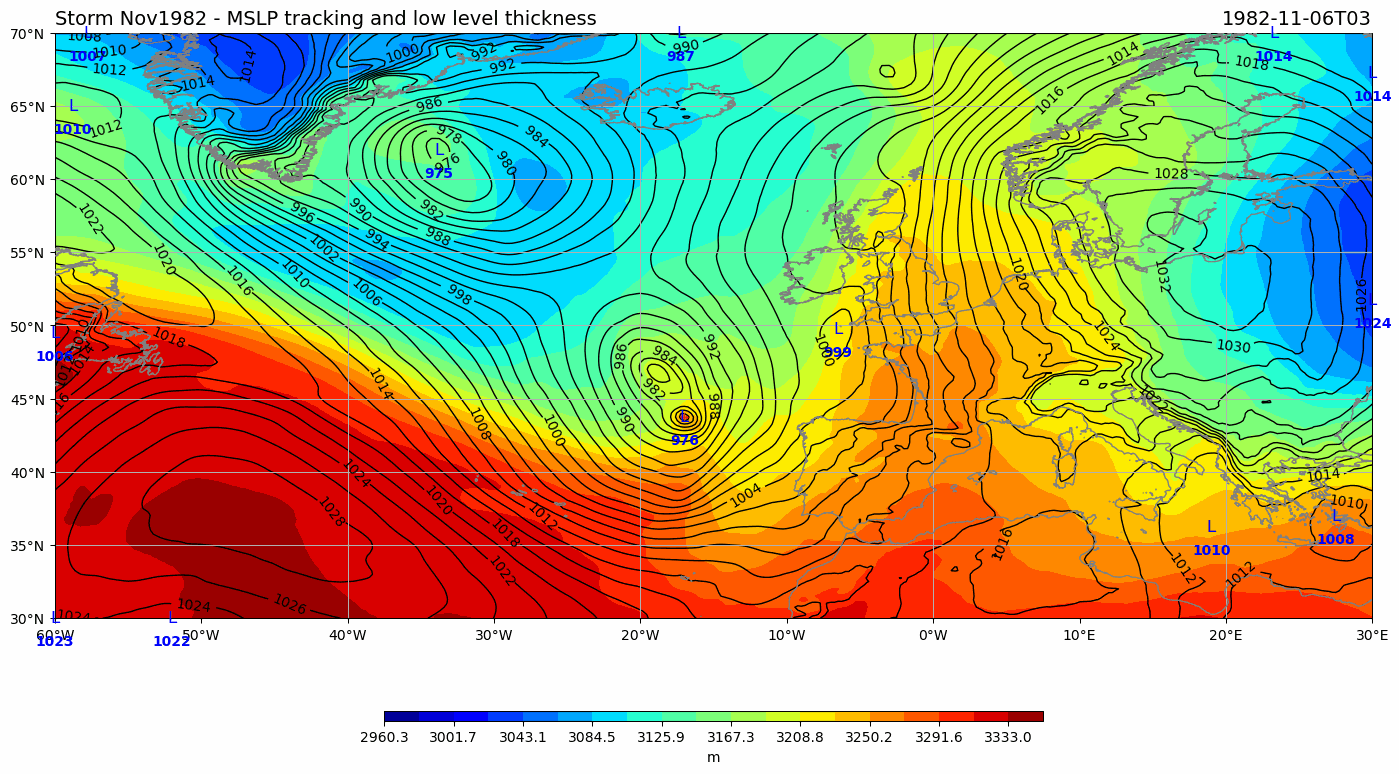

In [22]:
gif_filepath = dir_anim+'/MSL_thickness_tracking.gif'
make_animation(gif_filepath)

In [23]:
max_dist = 500      # max distance in km

for i in tqdm(range(len(time))):
    #print(str(time[i])[0:13])
    data_slp = mslp[i,:,:]
    data_thickness = thickness[i,:,:]
        
    # Center coordinates
    clat = liste_lat[i]
    clon = liste_lon[i] 
        
    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_slp_m = np.ma.masked_where(distance2 > max_dist, data_slp)
    data_thickness_m = np.ma.masked_where(distance2 > max_dist, data_thickness)

    fig = plt.figure(figsize=(17., 12.))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_title('Storm '+storm+' - MSLP tracking and low level thickness',loc='left',fontsize=14)
    ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    # MSLP in contours and min max
    c1 = ax.contour(lon, lat, data_slp_m, levels=mslp_levels,
                    colors="black", linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c1,fmt='%4.1i',fontsize=10)
    ax.scatter(liste_lon[i],liste_lat[i], c='green', transform=ccrs.PlateCarree())
    ax.plot(liste_lon[0:i+1],liste_lat[0:i+1], c='red', marker='+', transform=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, data_thickness_m, levels=dz_levels, 
                     cmap='jet', transform=ccrs.PlateCarree())
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
    cb.set_label('m')
    #plt.show()
    figname=dir_anim+'/MSL_tracking_zoom_'+str(time[i])[0:13]
    fig.savefig(figname+'.png',bbox_inches='tight')
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


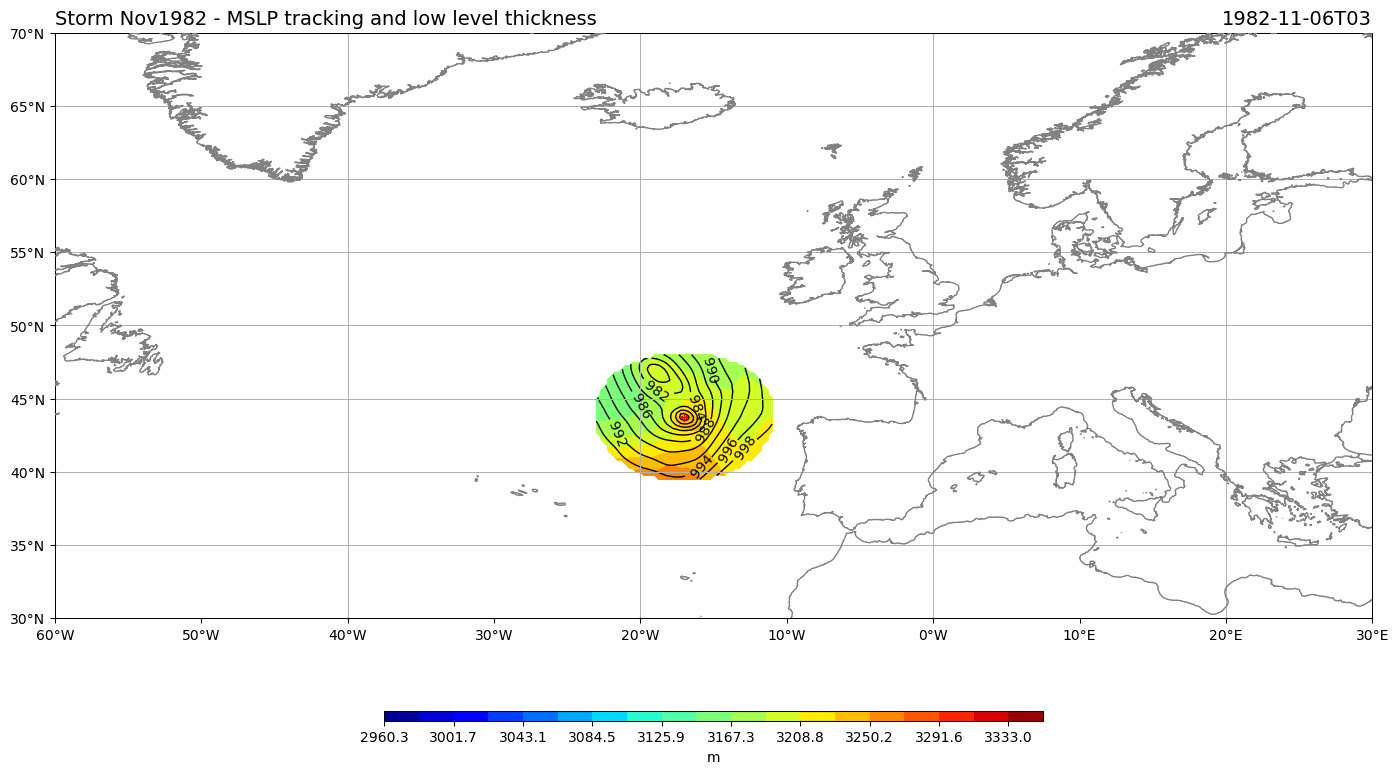

In [24]:
gif_filepath = dir_anim+'/MSL_tracking_zoom.gif'
make_animation(gif_filepath)

In [25]:
max_dist = int(input('Enter the value of the maximum radius (in km) to compute the CPS diagrams : ')) 

Enter the value of the maximum radius (in km) to compute the CPS diagrams : 500


# Calcul du paramètre de symétrie thermique du CPS

$$B=h*(\overline{Z_{600}-Z_{900}})_R-\overline{Z_{600}-Z_{900}})_L$$

h = hemisphere (1 = NH, -1 = SH).

$$(\overline{Z_{600}-Z_{900}})_R$$ : mean 900-600hPa thickness in semicircle right of motion

$$(\overline{Z_{600}-Z_{900}})_L$$ : mean 900-600hPa thickness in semicircle left of motion

In [27]:
print('Available dates : ', liste_time[0:-1])

date = input('Enter a date (YYYY-MM-DDTXX) : ')
data = thickness.sel(time=date)
data_slp = mslp.sel(time=date)
print(data)

idate = list(liste_time).index(date)
print('index of date : ', idate)

Available dates :  ['1982-11-06T03' '1982-11-06T09' '1982-11-06T15' '1982-11-06T21'
 '1982-11-07T03' '1982-11-07T09' '1982-11-07T15' '1982-11-07T21'
 '1982-11-08T03']
Enter a date (YYYY-MM-DDTXX) : 1982-11-07T09
<xarray.DataArray 'z' (latitude: 161, longitude: 361)>
array([[3064.5488, 3064.2898, 3064.0305, ..., 3137.4163, 3136.8977,
        3135.86  ],
       [3069.4758, 3069.476 , 3069.2168, ..., 3141.306 , 3140.7874,
        3139.7495],
       [3074.4033, 3074.1433, 3074.1438, ..., 3144.936 , 3144.1584,
        3143.3804],
       ...,
       [3322.3054, 3322.3057, 3322.5645, ..., 3294.04  , 3293.7808,
        3293.7808],
       [3322.824 , 3322.8242, 3322.8237, ..., 3296.1145, 3295.8557,
        3295.5964],
       [3323.3425, 3323.3428, 3323.3423, ..., 3297.4114, 3297.1523,
        3296.6335]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 30.5 30.25 30.0
    tim

In [29]:
clat = liste_lat[idate]
clon = liste_lon[idate]
ang=get_bearing(clat, clon, liste_lat[idate+1], liste_lon[idate+1])

In [30]:
qq_ang_all=np.zeros([len(lon),len(lat)],dtype='f')
for x in range(0,len(lon)):
    for y in range(0,len(lat)):
        qq_ang_all[x,y]=get_bearing(clat, clon, lat[y], lon[x])     
qq_ang_all=np.transpose(qq_ang_all)

In [31]:
Zl=np.zeros([len(lat),len(lon)],dtype='f')
Zr=np.zeros([len(lat),len(lon)],dtype='f')

for jlat in tqdm(range(0,len(lat)-1)):
    for jlon in range(0,len(lon)-1):
        #set values along great circle line to missing (neither left nor right)
        if qq_ang_all[jlat,jlon] == ang:
            Zl[jlat,jlon] = 0
            Zr[jlat,jlon] = 0
        #for storm travel angles in quadrants 1 and 2 (NE and SE)
        elif (ang >= 0 and ang < 180):
            if (qq_ang_all[jlat,jlon] > ang and qq_ang_all[jlat,jlon]  < ang+180):
                Zl[jlat,jlon] = 0
                Zr[jlat,jlon] = data[jlat,jlon]
            else:
                Zr[jlat,jlon] = 0
                Zl[jlat,jlon] = data[jlat,jlon]
        #for storm travel angles in quadrants 3 and 4 (NW and SW)
        elif (ang >= 180 and ang < 360):
            if (qq_ang_all[jlat,jlon] > ang-180 and qq_ang_all[jlat,jlon] < ang):
                Zr[jlat,jlon] = 0
                Zl[jlat,jlon] = data[jlat,jlon]
            else:
                Zl[jlat,jlon] = 0
                Zr[jlat,jlon] = data[jlat,jlon]

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:05<00:00, 29.34it/s]


In [32]:
# Calculate distance between center and all other lat/lon pairs
distance = haversine(lon[:,np.newaxis], lat, clon, clat)
distance2=np.transpose(distance)
# Mask distance array where distance > max_dist
distance_m = np.ma.masked_greater(distance2, max_dist)
# Mask the data array based on the distance mask
data_slp_m = np.ma.masked_where(distance2 > max_dist, data_slp)
Zr_m = np.ma.masked_where(distance2 > max_dist, Zr)
Zl_m = np.ma.masked_where(distance2 > max_dist, Zl)

Zr_m[Zr_m == 0] = np.nan
Zl_m[Zl_m == 0] = np.nan

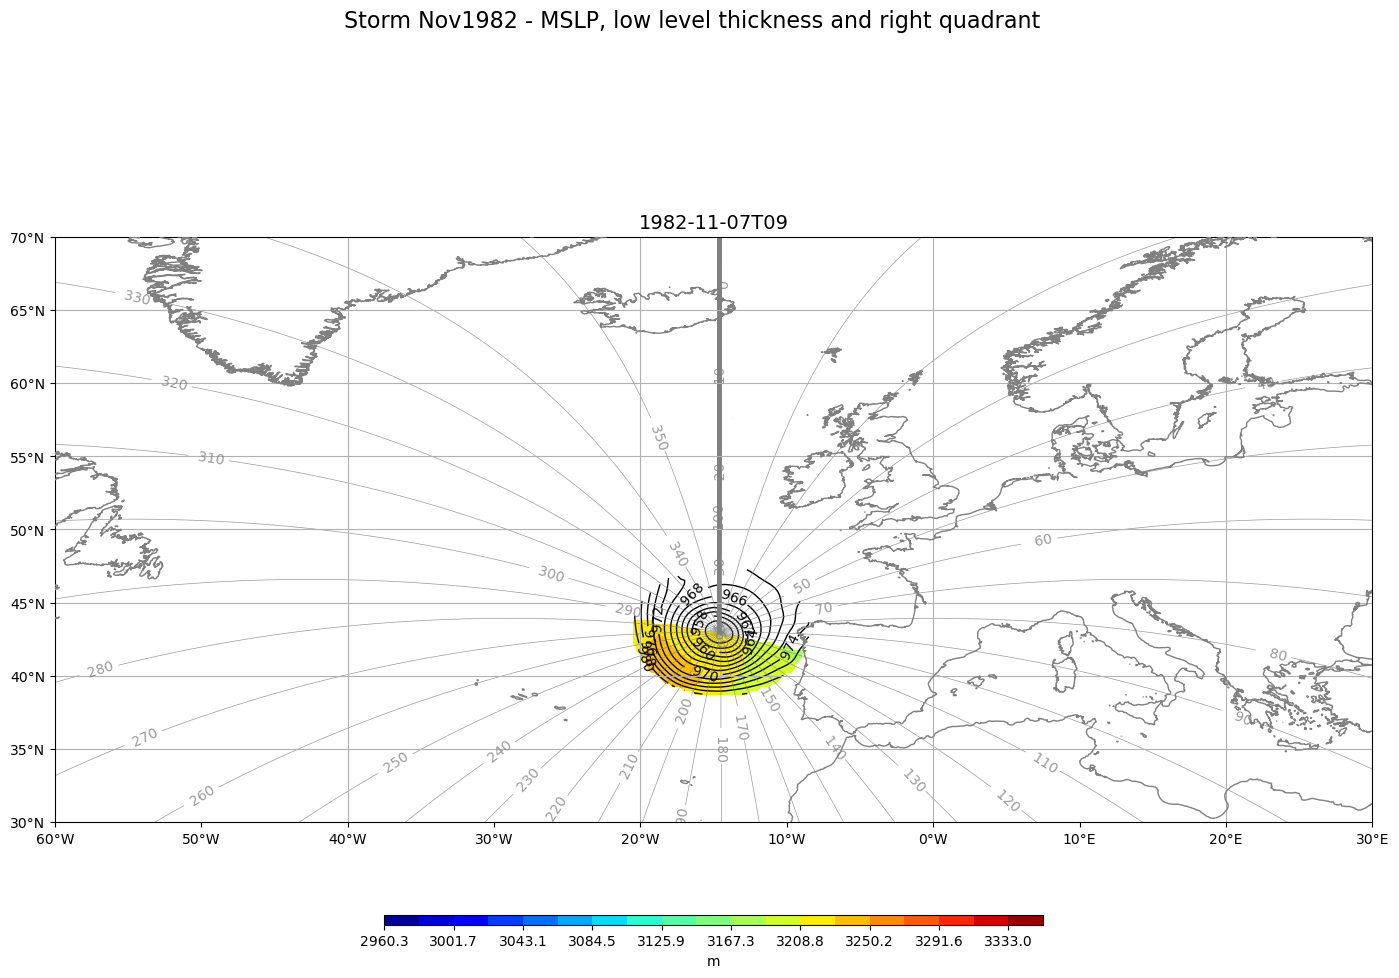

In [33]:
levels=np.arange(0,370,10)

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
fig.suptitle('Storm '+storm+' - MSLP, low level thickness and right quadrant',fontsize=16)
ax.set_title(liste_time[idate],fontsize=14)
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
 
c0 = ax.contour(lon, lat, data_slp_m, mslp_levels,
                colors="black", linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c0,fmt='%4.1i',fontsize=10)
cf1 = ax.contourf(lon, lat, Zr_m, dz_levels,
                 cmap='jet', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
cb.set_label('m')
c3 = ax.contour(lon, lat, qq_ang_all, levels,
                colors="grey", linewidths=0.5, alpha=0.8, transform=ccrs.PlateCarree())
ax.clabel(c3,fmt='%4.1i',fontsize=10)

plt.show()

figname=dir_figs+'/Thermal_symmetry0'
fig.savefig(figname+'.png',bbox_inches='tight')

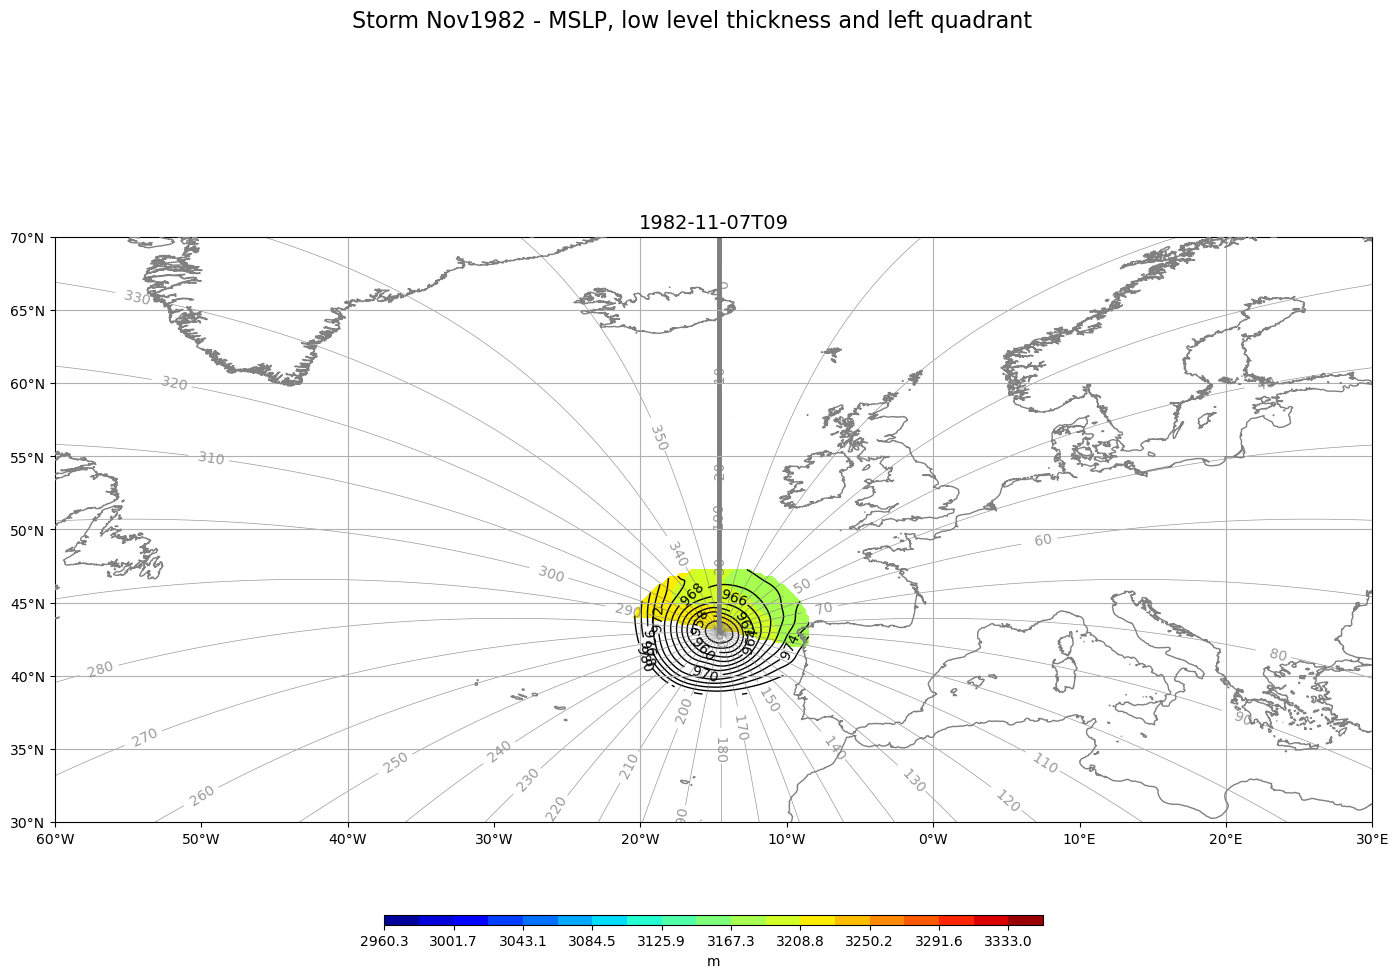

In [34]:
levels=np.arange(0,370,10)

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
fig.suptitle('Storm '+storm+' - MSLP, low level thickness and left quadrant',fontsize=16)
ax.set_title(liste_time[idate],fontsize=14)
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
 
c0 = ax.contour(lon, lat, data_slp_m, mslp_levels,
                colors="black", linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c0,fmt='%4.1i',fontsize=10)
cf2 = ax.contourf(lon, lat, Zl_m, dz_levels,
                 cmap='jet', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf2, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
cb.set_label('m')
c3 = ax.contour(lon, lat, qq_ang_all, levels,
                colors="grey", linewidths=0.5, alpha=0.8, transform=ccrs.PlateCarree())
ax.clabel(c3,fmt='%4.1i',fontsize=10)

plt.show()

figname=dir_figs+'/Thermal_symmetry1'
fig.savefig(figname+'.png',bbox_inches='tight')

In [35]:
# cyclone thermal symmetry parameter using classic average
Zr_mean=np.nanmean(Zr_m)
Zl_mean=np.nanmean(Zl_m)
B=Zr_mean-Zl_mean
print('Right quadrant thickness : ', Zr_mean)
print('Left quadrant thickness : ', Zl_mean)

if clat<0:
    B=-B

Right quadrant thickness :  3216.937
Left quadrant thickness :  3197.1135


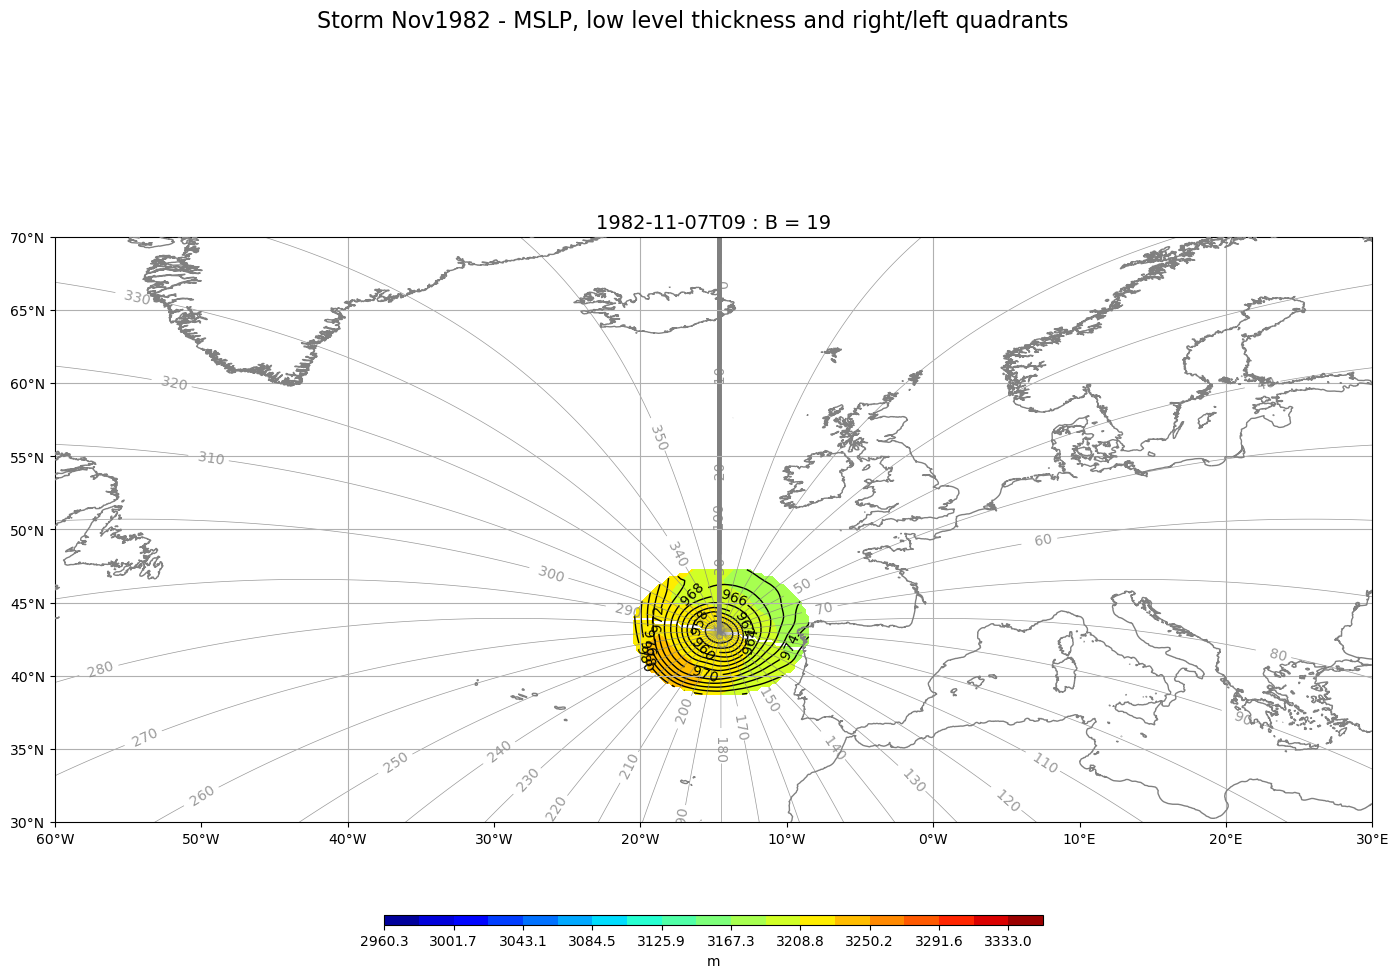

In [36]:
levels=np.arange(0,370,10)

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
fig.suptitle('Storm '+storm+' - MSLP, low level thickness and right/left quadrants',fontsize=16)
ax.set_title(liste_time[idate]+' : B = '+str(int(B)),fontsize=14)
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
 
c0 = ax.contour(lon, lat, data_slp_m, mslp_levels,
                colors="black", linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c0,fmt='%4.1i',fontsize=10)
cf1 = ax.contourf(lon, lat, Zr_m, dz_levels,
                 cmap='jet', transform=ccrs.PlateCarree())
cf2 = ax.contourf(lon, lat, Zl_m, dz_levels,
                 cmap='jet', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
cb.set_label('m')
c3 = ax.contour(lon, lat, qq_ang_all, levels,
                colors="grey", linewidths=0.5, alpha=0.8, transform=ccrs.PlateCarree())
ax.clabel(c3,fmt='%4.1i',fontsize=10)

plt.show()

figname=dir_figs+'/Thermal_symmetry'
fig.savefig(figname+'.png',bbox_inches='tight')

In [38]:
B_series=[]

for i in tqdm(range(len(time)-1)):
    #print(liste_time[i])
    data = thickness[i,:,:]
    data_slp = mslp[i,:,:]

    # Center coordinates
    clat = liste_lat[i]
    clon = liste_lon[i]

    # Calculate bearing between center and all other lat/lon pairs
    qq_ang_all=np.zeros([len(lon),len(lat)],dtype='f')
    for x in range(0,len(lon)):
        for y in range(0,len(lat)):
            qq_ang_all[x,y]=get_bearing(clat, clon, lat[y], lon[x])     
    qq_ang_all=np.transpose(qq_ang_all)

    # Angle of travel of the center
    ang=get_bearing(clat, clon, liste_lat[i+1], liste_lon[i+1])

    # Define right/left cadrans
    Zl=np.zeros([len(lat),len(lon)],dtype='f')
    Zr=np.zeros([len(lat),len(lon)],dtype='f')

    for jlat in range(0,len(lat)-1):
        for jlon in range(0,len(lon)-1):
            #set values along great circle line to missing (neither left nor right)
            if qq_ang_all[jlat,jlon] == ang:
                Zl[jlat,jlon] = 0
                Zr[jlat,jlon] = 0
            #for storm travel angles in quadrants 1 and 2 (NE and SE)
            elif (ang >= 0 and ang < 180):
                if (qq_ang_all[jlat,jlon] > ang and qq_ang_all[jlat,jlon]  < ang+180):
                    Zl[jlat,jlon] = 0
                    Zr[jlat,jlon] = data[jlat,jlon]
                else:
                    Zr[jlat,jlon] = 0
                    Zl[jlat,jlon] = data[jlat,jlon]
            #for storm travel angles in quadrants 3 and 4 (NW and SW)
            elif (ang >= 180 and ang < 360):
                if (qq_ang_all[jlat,jlon] > ang-180 and qq_ang_all[jlat,jlon] < ang):
                    Zr[jlat,jlon] = 0
                    Zl[jlat,jlon] = data[jlat,jlon]
                else:
                    Zl[jlat,jlon] = 0
                    Zr[jlat,jlon] = data[jlat,jlon]

    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_slp_m = np.ma.masked_where(distance2 > max_dist, data_slp)
    Zr_m = np.ma.masked_where(distance2 > max_dist, Zr)
    Zl_m = np.ma.masked_where(distance2 > max_dist, Zl)
    
    Zr_m[Zr_m == 0] = np.nan
    Zl_m[Zl_m == 0] = np.nan

    # cyclone thermal symmetry parameter using weighted average
    Zr_mean=np.nanmean(Zr_m)
    Zl_mean=np.nanmean(Zl_m)
    B=Zr_mean-Zl_mean
    
    if clat<0:
        B=-B
    #print('B = ',B)
    
    B_series.append(B)

    fig = plt.figure(figsize=(17., 12.))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    fig.suptitle('Storm '+storm+' - MSLP, low level thickness and right/left quadrants',fontsize=16)
    ax.set_title(liste_time[i]+' : B = '+str(int(B)),fontsize=14)
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())

    c0 = ax.contour(lon, lat, data_slp_m, mslp_levels,
                    colors="black", linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c0,fmt='%4.1i',fontsize=10)
    cf1 = ax.contourf(lon, lat, Zr_m, dz_levels,
                     cmap='jet', transform=ccrs.PlateCarree())
    cf2 = ax.contourf(lon, lat, Zl_m, dz_levels,
                     cmap='jet', transform=ccrs.PlateCarree())
    cb = fig.colorbar(cf1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
    cb.set_label('m')
    c3 = ax.contour(lon, lat, qq_ang_all, levels,
                    colors="grey", linewidths=0.5, alpha=0.8, transform=ccrs.PlateCarree())
    ax.clabel(c3,fmt='%4.1i',fontsize=10)

    #plt.show()
    figname=dir_anim+'/Thermal_symmetry_'+liste_time[i]
    fig.savefig(figname+'.png',bbox_inches='tight')
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:01<00:00,  6.86s/it]


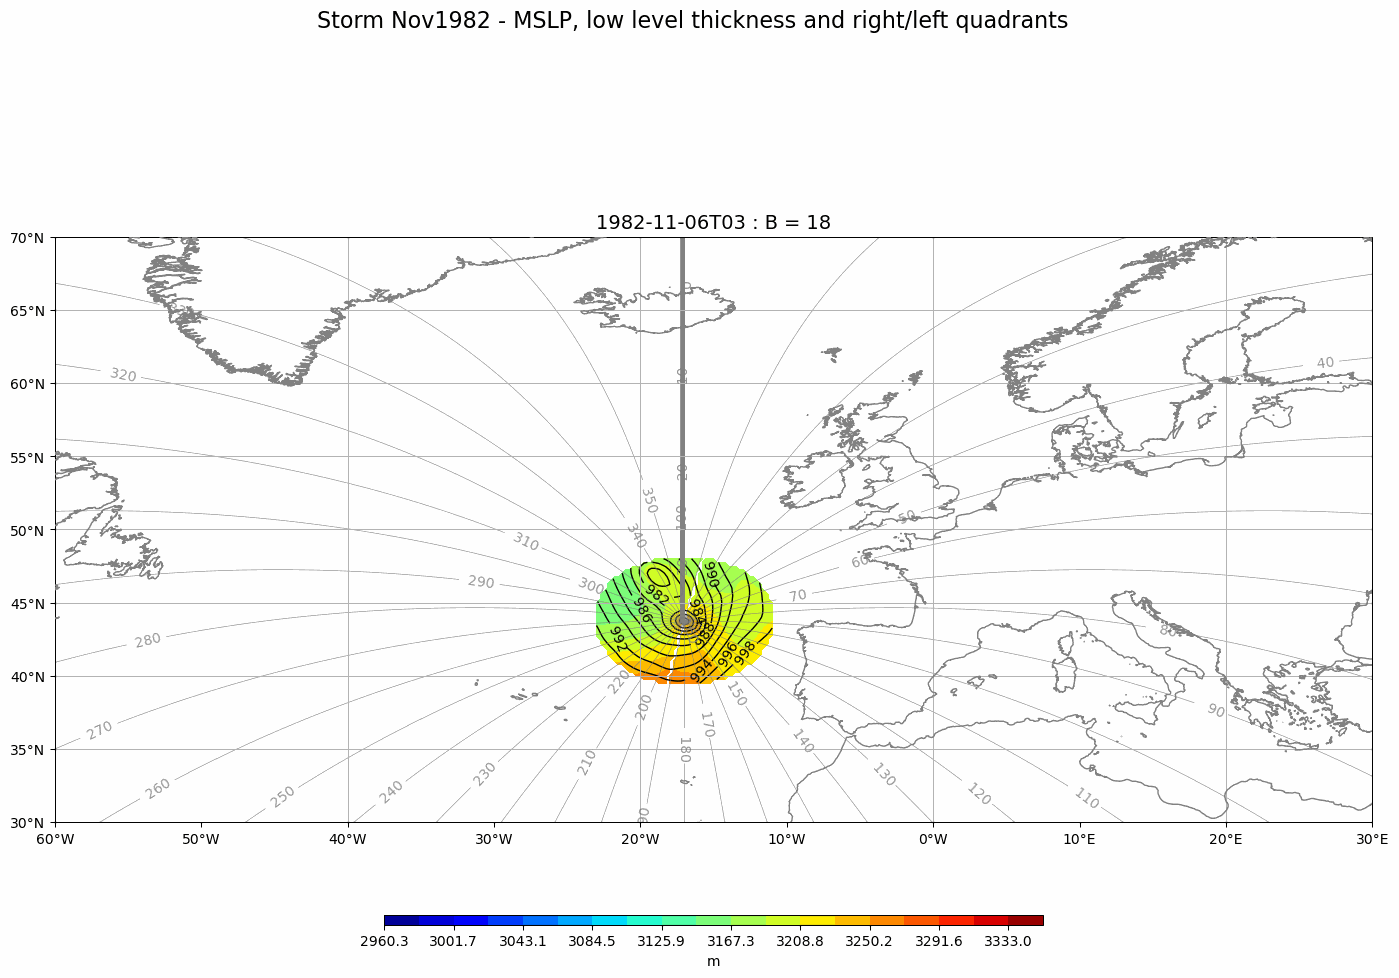

In [39]:
gif_filepath = dir_anim+'/Thermal_symmetry.gif'
make_animation(gif_filepath)

[18.992676, 27.758545, -44.79419, -10.759766, 10.23291, 19.823486, 21.687012, 25.633057, 29.631836]


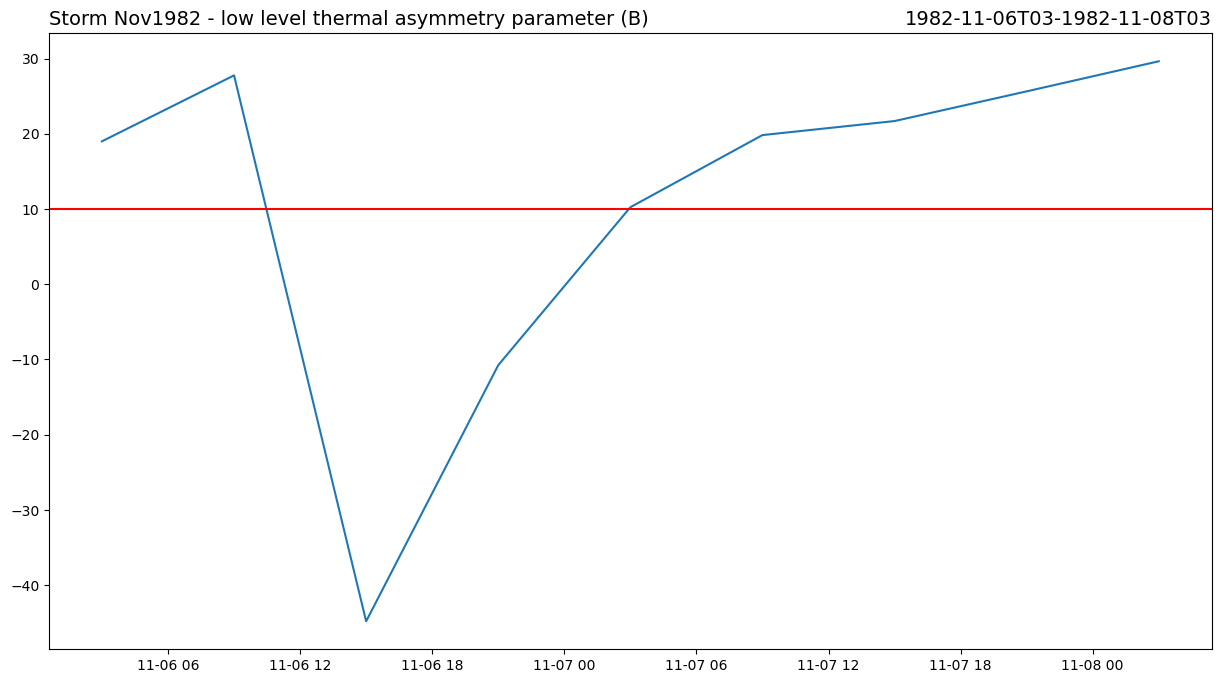

In [40]:
print(B_series)

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - low level thermal asymmetry parameter (B)'
             ,loc='left',fontsize=14)
ax.set_title(liste_time[0]+'-'+liste_time[-2],loc='right',fontsize=14)
ax.plot(time[0:-1], B_series, label='B')
plt.axhline(y=10, color='r')

figname=dir_figs+'/Thermal_symmetry_timeseries'
fig.savefig(figname+'.png',bbox_inches='tight')

# Calcul du paramètre de coeur chaud/coeur froid du CPS

Approximation of the height gradient on an isobaric surface (i.e. magnitude of the geostrophic wind) :

$$\Delta{Z}=Z_{max}-Z_{min}$$

Magnitude of the cyclone thermal wind measured as the vertical profile of cyclone geopotential height gradient (cyclone strength) :

$$-V_T^L=\frac{\partial{\Delta Z}}{\partial{ln(P)}}_{900}^{600}$$

$$-V_T^U=\frac{\partial{\Delta Z}}{\partial{ln(P)}}_{600}^{300}$$

In [41]:
print('Available dates : ', liste_time[0:-1])

date = input('Enter a date (YYYY-MM-DDTXX) : ')
data = thickness.sel(time=date)
data_slp = mslp.sel(time=date)
print(data)

idate = list(liste_time).index(date)
print('index of date : ', idate)

Available dates :  ['1982-11-06T03' '1982-11-06T09' '1982-11-06T15' '1982-11-06T21'
 '1982-11-07T03' '1982-11-07T09' '1982-11-07T15' '1982-11-07T21'
 '1982-11-08T03']
Enter a date (YYYY-MM-DDTXX) : 1982-11-06T09
<xarray.DataArray 'z' (latitude: 161, longitude: 361)>
array([[3074.403 , 3073.3657, 3072.588 , ..., 3087.1094, 3084.7754,
        3082.1826],
       [3082.7014, 3081.664 , 3080.3674, ..., 3087.8872, 3085.294 ,
        3082.9602],
       [3090.4807, 3089.1838, 3087.8872, ..., 3088.1465, 3085.8127,
        3083.2192],
       ...,
       [3325.4167, 3324.38  , 3323.343 , ..., 3295.5957, 3295.5964,
        3295.5964],
       [3325.1577, 3324.121 , 3323.0835, ..., 3297.152 , 3297.1523,
        3296.893 ],
       [3325.1577, 3324.3804, 3323.3423, ..., 3298.7083, 3298.7078,
        3298.7075]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 30.5 30.25 30.0
    tim

In [42]:
clat = liste_lat[idate]
clon = liste_lon[idate]

deltaZ1=[]
deltaZ2=[]

#low layer loop
for plev in listlev1:

    ilev = list(lev).index(plev)
    data_z1 = z[idate,ilev,:,:]

    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_z1_m = np.ma.masked_where(distance2 > max_dist, data_z1)
    zmin=np.min(data_z1_m)
    zmax=np.max(data_z1_m)
    delta_z1=zmax-zmin
    deltaZ1.append(int(delta_z1))

#high layer loop
for plev in listlev2:

    ilev = list(lev).index(plev)
    data_z2 = z[idate,ilev,:,:]

    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_z2_m = np.ma.masked_where(distance2 > max_dist, data_z2)
    zmin=np.min(data_z2_m)
    zmax=np.max(data_z2_m)
    delta_z2=zmax-zmin
    deltaZ2.append(int(delta_z2))

8925.756
8701.45


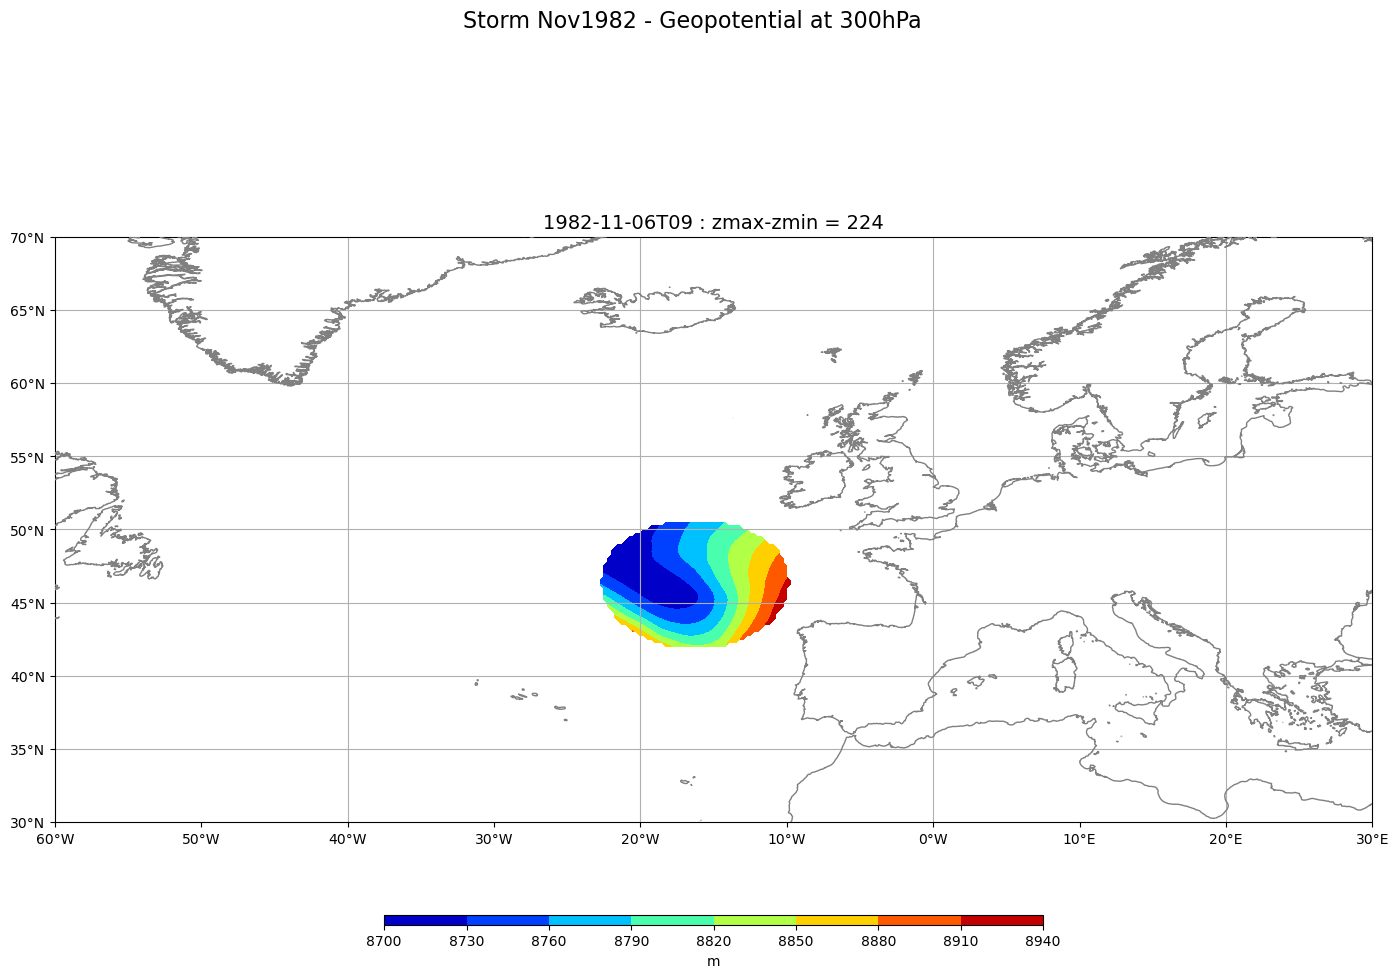

In [44]:
print(zmax)
print(zmin)

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
fig.suptitle('Storm '+storm+' - Geopotential at '+str(plev)+ 'hPa',fontsize=16)
ax.set_title(liste_time[idate]+ ' : zmax-zmin = '+str(int(delta_z2)),fontsize=14)
plot_background(ax)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
 
cf = ax.contourf(lon, lat, data_z2_m,
                     cmap='jet', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
cb.set_label('m')

plt.show()

figname=dir_figs+'/deltaz_map'
fig.savefig(figname+'.png',bbox_inches='tight')

In [45]:
print("Lower layer vertical levels : ", listlev1)
print("Lower layer deltaZ : ", deltaZ1)
print("Higher layer vertical levels : ", listlev2)
print("Higher layer deltaZ : ", deltaZ2)

listlev11=[n * 100 for n in listlev1]
lnP1=np.log(listlev11)

listlev22=[n * 100 for n in listlev2]
lnP2=np.log(listlev22)

Lower layer vertical levels :  [900, 800, 700, 600]
Lower layer deltaZ :  [214, 205, 201, 200]
Higher layer vertical levels :  [600, 500, 400, 300]
Higher layer deltaZ :  [200, 207, 229, 224]


In [46]:
VTL_series=[]
VTU_series=[]

for i in tqdm(range(len(time)-1)):
    #print(liste_time[i])

    # Center coordinates
    clat = liste_lat[i]
    clon = liste_lon[i]
    deltaZ1=[]
    deltaZ2=[]

    for plev in listlev1:

        ilev = list(lev).index(plev)
        data_z1 = z[i,ilev,:,:]
        # Calculate distance between center and all other lat/lon pairs
        distance = haversine(lon[:,np.newaxis], lat, clon, clat)
        distance2=np.transpose(distance)
        # Mask distance array where distance > max_dist
        distance_m = np.ma.masked_greater(distance2, max_dist)
        # Mask the data array based on the distance mask
        data_z1_m = np.ma.masked_where(distance2 > max_dist, data_z1)
        zmin=np.min(data_z1_m)
        zmax=np.max(data_z1_m)
        delta_z1=zmax-zmin
        deltaZ1.append(int(delta_z1))

    for plev in listlev2:

        ilev = list(lev).index(plev)
        data_z2 = z[i,ilev,:,:]

        # Calculate distance between center and all other lat/lon pairs
        distance = haversine(lon[:,np.newaxis], lat, clon, clat)
        distance2=np.transpose(distance)
        # Mask distance array where distance > max_dist
        distance_m = np.ma.masked_greater(distance2, max_dist)
        # Mask the data array based on the distance mask
        data_z2_m = np.ma.masked_where(distance2 > max_dist, data_z2)
        zmin=np.min(data_z2_m)
        zmax=np.max(data_z2_m)
        delta_z2=zmax-zmin
        deltaZ2.append(int(delta_z2))

    coef1=(deltaZ1[-1]-deltaZ1[0])/(lnP1[-1]-lnP1[0])
    VTL_series.append(int(coef1))

    coef2=(deltaZ2[-1]-deltaZ2[0])/(lnP2[-1]-lnP2[0])
    VTU_series.append(int(coef2))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 55.42it/s]


[-288, -34, -23, -49, -4, -20, -98, -122, -160]
[-54, 34, 51, 69, 9, -9, -44, -14, -93]


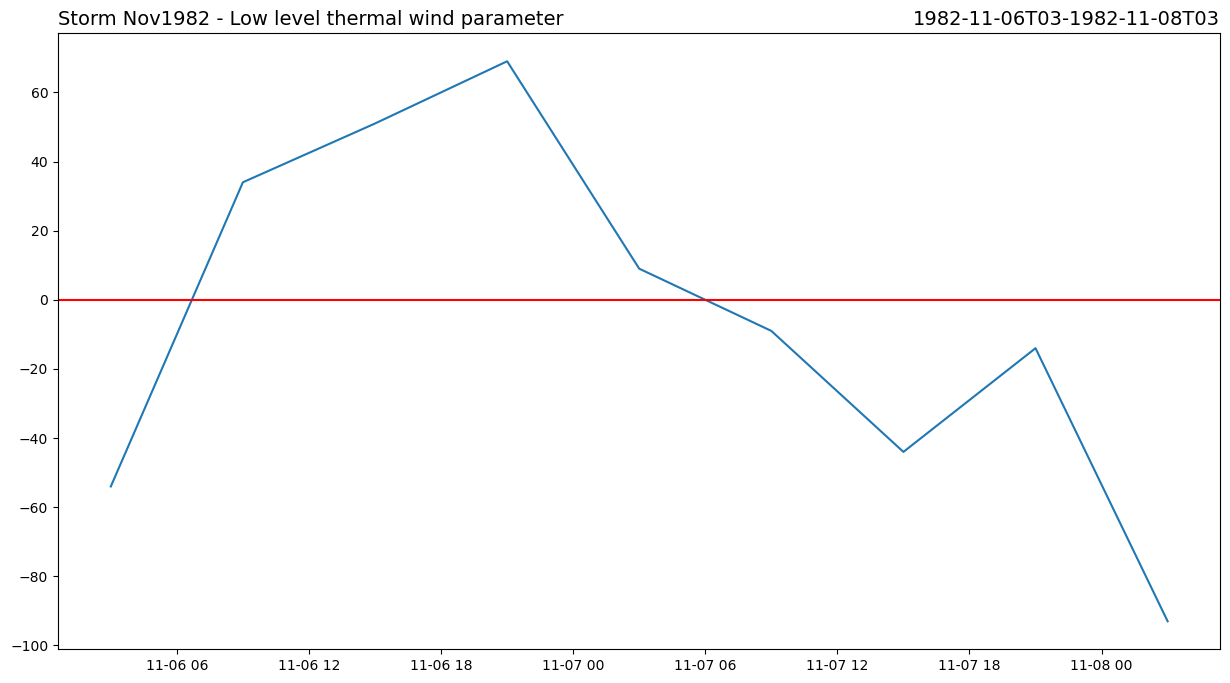

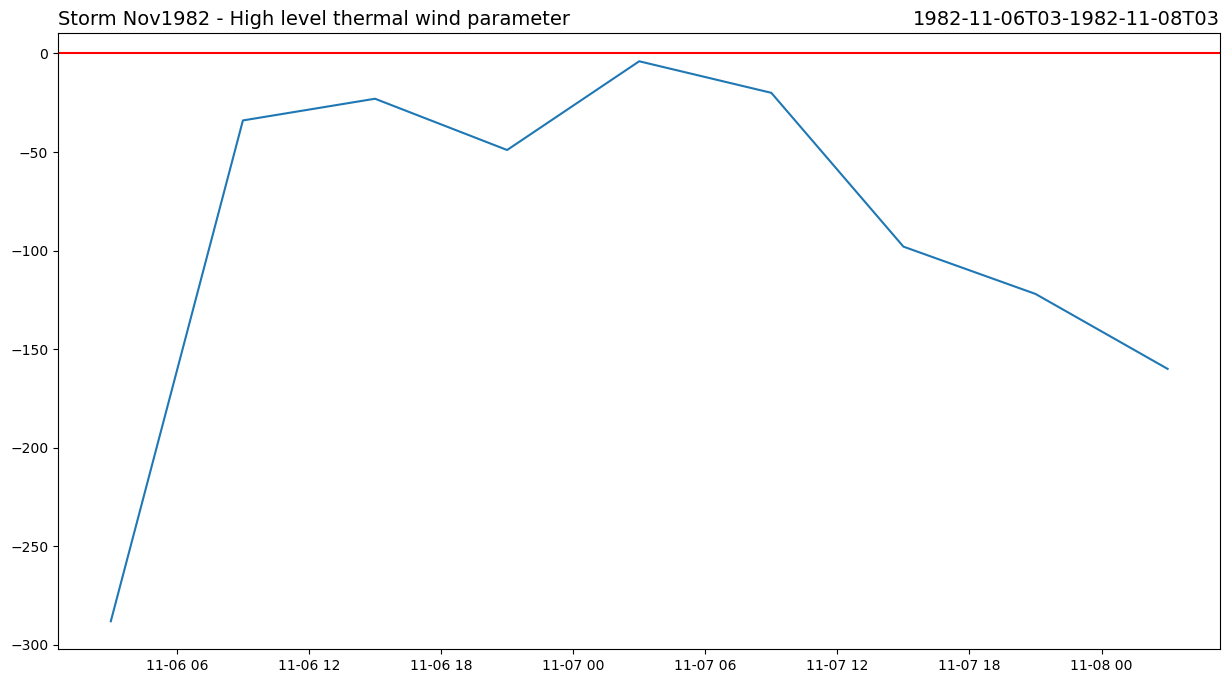

In [49]:
print(VTU_series)
print(VTL_series)

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - Low level thermal wind parameter'
             ,loc='left',fontsize=14)
ax.set_title(liste_time[0]+'-'+liste_time[-2],loc='right',fontsize=14)
ax.plot(time[0:-1], VTL_series, label='-$VT_T^L$')

plt.axhline(y=0, color='r')

plt.show()

figname=dir_figs+'/VTL_timeseries'
fig.savefig(figname+'.png',bbox_inches='tight')

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - High level thermal wind parameter'
             ,loc='left',fontsize=14)
ax.set_title(liste_time[0]+'-'+liste_time[-2],loc='right',fontsize=14)
ax.plot(time[0:-1], VTU_series, label='-$VT_T^U$')

plt.axhline(y=0, color='r')

plt.show()

figname=dir_figs+'/VTU_timeseries'
fig.savefig(figname+'.png',bbox_inches='tight')

In [50]:
time_str=[x for x in range(len(time)-1)]
date_str=[x for x in range(len(time)-1)]
for i in range(len(time)-1):
    time_str[i] = str(time[i])
    date_str[i] = time_str[i][5:13]

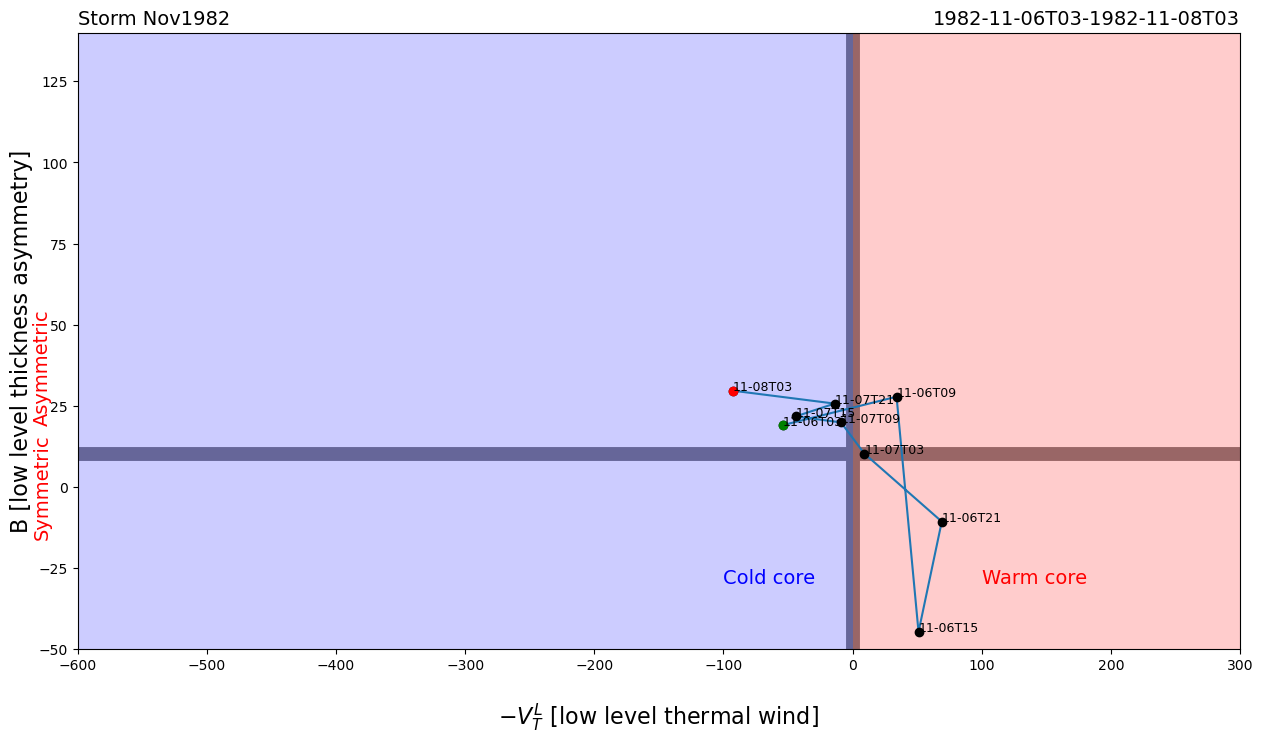

In [51]:
x1=-600
x2=300
y1=-50
y2=140

if storm=='Zorbas':
    x1=-200
    x2=300
    y1=-50
    y2=60
    
fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm,loc='left',fontsize=14)
ax.set_title(liste_time[0]+'-'+liste_time[-2],loc='right',fontsize=14)
plt.axhline(y=10, color='grey', linewidth=10,zorder=1)
plt.axvline(x=0, color='grey', linewidth=10,zorder=1)
plt.plot(VTL_series, B_series)
plt.scatter(VTL_series,  B_series, c='k',zorder=2)
plt.scatter(VTL_series[0], B_series[0], c='green',zorder=2)
plt.scatter(VTL_series[-1], B_series[-1], c='red',zorder=2)
plt.xlabel("$-V_T^L$ [low level thermal wind]", labelpad=20, fontsize = 16)
plt.ylabel("B [low level thickness asymmetry]", fontsize = 16)

plt.text(x1-35,-15,'Symmetric', rotation=90., color='red', fontsize = 14)
plt.text(x1-35, 20,'Asymmetric', rotation=90., color='red', fontsize = 14)
plt.text(-100, -30,'Cold core', rotation=0., color='blue', fontsize = 14)
plt.text(100, -30,'Warm core', rotation=0., color='red', fontsize = 14)
plt.xlim(x1, x2)
plt.ylim(y1, y2)
    
for i,type in enumerate(date_str):
    x = VTL_series[i]
    y = B_series[i]
    plt.text(x, y, type, fontsize=9)
    
xrange = [(x1, -x1)]
yrange1 = (y1, y1+110)

c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='blue', alpha=0.2)
ax.add_collection(c1)
xrange = [(x1, -x1)]
yrange1 = (10, 10+120)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='blue', alpha=0.2)
ax.add_collection(c1)

xrange = [(0, 0+x2)]
yrange1 = (y1, y1+110)

c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='red', alpha=0.2)
ax.add_collection(c1)
xrange = [(0, 0+x2)]
yrange1 = (10, 10+120)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='red', alpha=0.2)
ax.add_collection(c1)

plt.show()

figname=dir_figs+'/CPS1'
fig.savefig(figname+'.png',bbox_inches='tight')

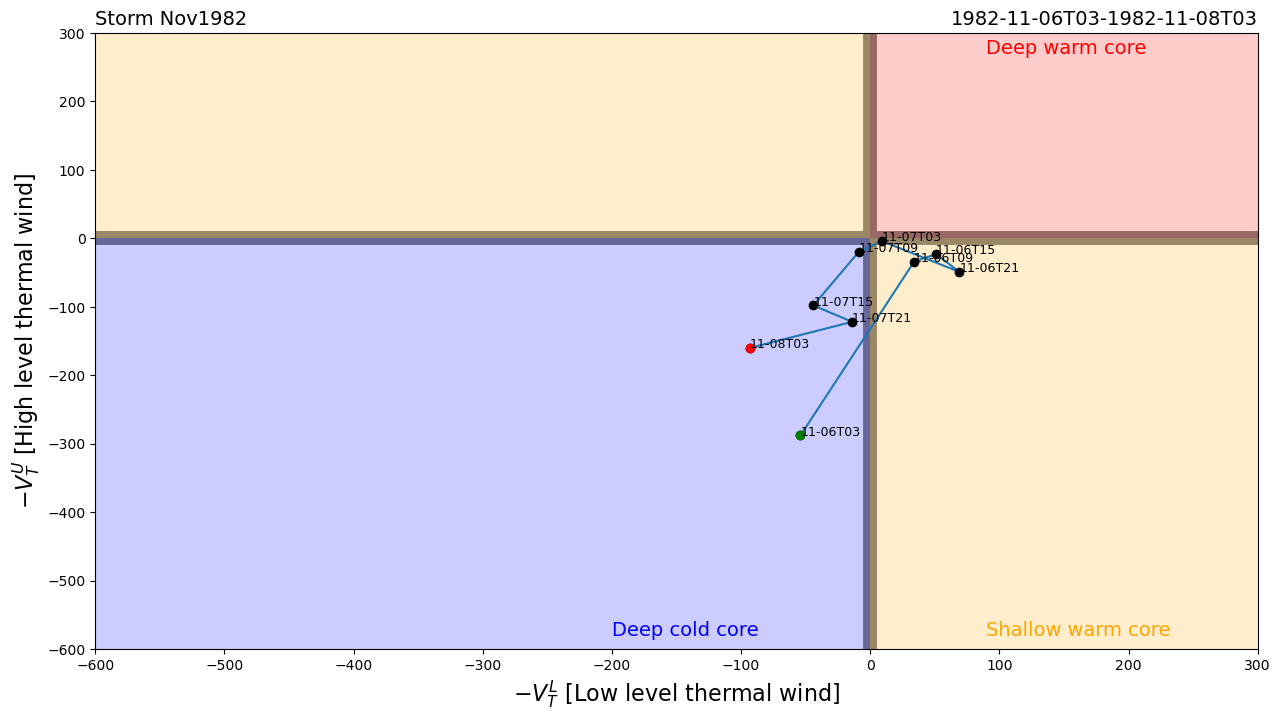

In [52]:
if storm=='Zorbas':
    x1=-300
    x2=300
    y1=-300
    y2=300

else:
    x1=-600
    x2=300
    y1=-600
    y2=300

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm,loc='left',fontsize=14)
ax.set_title(liste_time[0]+'-'+liste_time[-2],loc='right',fontsize=14)
plt.axhline(y=0, color='grey', linewidth=10,zorder=1)
plt.axvline(x=0, color='grey', linewidth=10,zorder=1)
plt.plot(VTL_series, VTU_series)
plt.scatter(VTL_series, VTU_series, c='k',zorder=2)
plt.scatter(VTL_series[0], VTU_series[0], c='green',zorder=2)
plt.scatter(VTL_series[-1], VTU_series[-1], c='red',zorder=2)

plt.xlabel("$-V_T^L$ [Low level thermal wind]", fontsize = 16)
plt.ylabel("$-V_T^U$ [High level thermal wind]", fontsize = 16)
plt.text(-200, y1+20,'Deep cold core', rotation=0., color='blue', fontsize = 14)
plt.text(90, 270,'Deep warm core', rotation=0., color='red', fontsize = 14)
plt.text(90, y1+20,'Shallow warm core', rotation=0., color='orange', fontsize = 14)

plt.xlim(x1, x2)
plt.ylim(y1, y2)

for i,type in enumerate(date_str):
    x = VTL_series[i]
    y = VTU_series[i]
    plt.text(x, y, type, fontsize=9)

xrange = [(0, 0+x2)]
yrange1 = (0, 0+y2)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='r', alpha=0.2)
ax.add_collection(c1)
xrange = [(-600, 600)]
yrange1 = (-600, 600)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='b', alpha=0.2)
ax.add_collection(c1)
xrange = [(x1, -x1)]
yrange1 = (0, 300)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='orange', alpha=0.2)
ax.add_collection(c1)
xrange = [(0, x2)]
yrange1 = (y1, -y1)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='orange', alpha=0.2)
ax.add_collection(c1)

plt.show()

figname=dir_figs+'/CPS2'
fig.savefig(figname+'.png',bbox_inches='tight')